<a href="https://colab.research.google.com/github/Souhib-khalbous/Heart-Disease-Classification-Using-ECG-Signals/blob/master/ConvNetQuacke_ECG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import the drive module from the google.colab library to enable Google Drive integration
from google.colab import drive
# Mount your Google Drive to the Colab VM to access files directly from your Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from scipy.io import loadmat

# Metrics for evaluating model performance
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [ ]:
import h5py

# Specify the path to the dataset
features_path = '/content/drive/MyDrive/Full Datasets (PTB and MIT)/Feature Extracted by Hatem/PTB_Features2.mat'

# Open the HDF5 file and directly access the 'f' dataset
with h5py.File(features_path, 'r') as file: #'r' means: read only mode, file= the content of the feature path
    # Directly print the shape of the 'f' dataset
    print("'f' dataset shape:", file['f'].shape)


'f' dataset shape: (1, 549)


In [ ]:
from scipy.io import loadmat

# Correctly specify the path to the labels dataset
labels_path = '/content/drive/MyDrive/Full Datasets (PTB and MIT)/Feature Extracted by Hatem/patientDiagnoses.mat'

# Load the labels dataset
label_data = loadmat(labels_path)

# Access the diagnosis data, assuming 'patientInfo' is the struct and 'diagnosis' is the field
# This correction is based on the detailed structure you've provided earlier
labels = [label[0] for label in label_data['patientInfo']['diagnosis'][0]]

print("Labels loaded. Sample label data:", labels[:5])  # Print the first 5 labels to inspect


Labels loaded. Sample label data: ['Valvular heart disease', 'Myocardial infarction', 'Myocardial infarction', 'n/a', 'Unstable angina']


LET'S TEST

In [ ]:
import numpy as np
import h5py
from scipy.io import loadmat
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder

# Paths to the datasets
features_path = '/content/drive/MyDrive/Full Datasets (PTB and MIT)/Feature Extracted by Hatem/PTB_Features2.mat'
labels_path = '/content/drive/MyDrive/Full Datasets (PTB and MIT)/Feature Extracted by Hatem/patientDiagnoses.mat'


# Load features from HDF5
with h5py.File(features_path, 'r') as file:
    refs = file['#refs#']
    features_data = np.array(file['f']).flatten()  # Ensure 'f' data is appropriately flattened
    extracted_features = [np.array(refs[ref]) for ref in features_data]

# Load labels from MAT file
label_data = loadmat(labels_path)
labels = [label[0] for label in label_data['patientInfo']['diagnosis'][0]]

# Eliminate classes, only keep 'Myocardial infarction' and 'Healthy control'
desired_labels = ['Myocardial infarction', 'Healthy control']
indices = [i for i, label in enumerate(labels) if label in desired_labels]
filtered_features = np.array(extracted_features)[indices]
filtered_labels = np.array(labels)[indices]



print("Labels after preprocessing:")
print(filtered_labels[:50])   # Print the first 5 labels

# Encoding labels
le = LabelEncoder()
encoded_labels = le.fit_transform(filtered_labels)

# Initialize LeaveOneOut cross-validation
loo = LeaveOneOut()

# Placeholder for the results
results = []


Labels after preprocessing:
['Myocardial infarction' 'Myocardial infarction' 'Myocardial infarction'
 'Myocardial infarction' 'Myocardial infarction' 'Myocardial infarction'
 'Myocardial infarction' 'Myocardial infarction' 'Myocardial infarction'
 'Myocardial infarction' 'Myocardial infarction' 'Myocardial infarction'
 'Myocardial infarction' 'Myocardial infarction' 'Myocardial infarction'
 'Myocardial infarction' 'Myocardial infarction' 'Myocardial infarction'
 'Myocardial infarction' 'Healthy control' 'Myocardial infarction'
 'Myocardial infarction' 'Myocardial infarction' 'Myocardial infarction'
 'Myocardial infarction' 'Myocardial infarction' 'Myocardial infarction'
 'Myocardial infarction' 'Myocardial infarction' 'Myocardial infarction'
 'Myocardial infarction' 'Myocardial infarction' 'Myocardial infarction'
 'Myocardial infarction' 'Myocardial infarction' 'Myocardial infarction'
 'Myocardial infarction' 'Myocardial infarction' 'Myocardial infarction'
 'Myocardial infarction' 'Myo

In [ ]:
# Count occurrences of each class in the dataset
unique_classes, counts = np.unique(encoded_labels, return_counts=True)
class_counts = dict(zip(le.inverse_transform(unique_classes), counts))

print("Number of samples per class:")
for label, count in class_counts.items():
    print(f"{label}: {count}")


Number of samples per class:
Healthy control: 80
Myocardial infarction: 368


In [ ]:
print("Shape of filtered_features:", filtered_features.shape)
print("Shape of encoded_labels:", encoded_labels.shape)


Shape of filtered_features: (448, 526, 15)
Shape of encoded_labels: (448,)


oversampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Reshape filtered_features to 2D array
reshaped_features = filtered_features.reshape(filtered_features.shape[0], -1)

# Initialize RandomOverSampler
random_oversampler = RandomOverSampler(random_state=42)

# Resample using Random Oversampling
oversampled_features_random, oversampled_labels_random = random_oversampler.fit_resample(reshaped_features, encoded_labels)

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Resample using SMOTE
oversampled_features_smote, oversampled_labels_smote = smote.fit_resample(reshaped_features, encoded_labels)


ConvNet approach after oversampling

In [ ]:
print("Shape of reshaped_features:", reshaped_features.shape)


Shape of reshaped_features: (448, 7890)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import confusion_matrix
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

# Define ConvNetQuakcke model
def ConvNetQuakcke(input_shape):
    model = Sequential([
        Conv1D(32, 3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(2),
        Conv1D(64, 3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model



def ConvNetQuakcke(input_shape):
    model = Sequential([
        Conv1D(32, 3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(2),
        Conv1D(64, 3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

# Input shape based on the reshaped features
input_shape = (reshaped_features.shape[1], 1)

# Create the model
model = ConvNetQuakcke(input_shape)

# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy', sensitivity, specificity, precision])

# Print model summary
model.summary()


TensorFlow version: 2.15.0
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 7888, 32)          128       
                                                                 
 batch_normalization_6 (Bat  (None, 7888, 32)          128       
 chNormalization)                                                
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 3944, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 3942, 64)          6208      
                                                                 
 batch_normalization_7 (Bat  (None, 3942, 64)          256       
 chNormalization)                                                
                           

In [ ]:
# Train the model
history = model.fit(oversampled_features_random, oversampled_labels_random,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=10,
                    verbose=1)

# Evaluate the model on test data (example)
loss, accuracy, sensitivity, specificity, precision = model.evaluate(oversampled_features_smote, oversampled_labels_smote)

# Print evaluation metrics
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test Sensitivity:", sensitivity)
print("Test Specificity:", specificity)
print("Test Precision:", precision)


Epoch 1/100
59/59 [==============================] - 31s 517ms/step - loss: 4.2429 - accuracy: 0.7823 - sensitivity: 0.8082 - specificity: 0.6946 - precision: 0.8214 - val_loss: 0.0491 - val_accuracy: 0.9865 - val_sensitivity: 0.0000e+00 - val_specificity: 0.9867 - val_precision: 0.0000e+00
Epoch 2/100
59/59 [==============================] - 29s 497ms/step - loss: 1.2674 - accuracy: 0.8452 - sensitivity: 0.8904 - specificity: 0.7648 - precision: 0.8702 - val_loss: 1.0311 - val_accuracy: 0.8514 - val_sensitivity: 0.0000e+00 - val_specificity: 0.8500 - val_precision: 0.0000e+00
Epoch 3/100
59/59 [==============================] - 29s 501ms/step - loss: 0.3688 - accuracy: 0.9116 - sensitivity: 0.9512 - specificity: 0.8193 - precision: 0.9126 - val_loss: 2.6442 - val_accuracy: 0.8311 - val_sensitivity: 0.0000e+00 - val_specificity: 0.8300 - val_precision: 0.0000e+00
Epoch 4/100
59/59 [==============================] - 29s 487ms/step - loss: 0.2182 - accuracy: 0.9371 - sensitivity: 0.9736 

# **Leave one subject out approach**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Prepare classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Classifier': SVC(probability=True, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Dictionary to hold the results for each classifier
classifier_results = {name: [] for name in classifiers}

# Perform LOOCV
for train_index, test_index in loo.split(filtered_features):
    # Split data into this fold's training and test sets
    X_train, X_test = filtered_features[train_index], filtered_features[test_index]
    y_train, y_test = encoded_labels[train_index], encoded_labels[test_index]

    # Iterate over each classifier
    for name, classifier in classifiers.items():
        # Track individual channel predictions for the test subject
        channel_predictions = []

        # Iterate over each channel and train the classifier
        for channel_index in range(X_train.shape[2]):  # Assuming shape is (subjects, channels, features)
            # Extract the data for this channel
            X_train_channel = X_train[:, channel_index, :]
            X_test_channel = X_test[:, channel_index, :].reshape(1, -1)  # Reshape for single sample

            # Train the classifier
            classifier.fit(X_train_channel, y_train)

            # Predict the label for this channel
            channel_prediction = classifier.predict(X_test_channel)
            channel_predictions.append(channel_prediction)

        # Apply majority voting for the test subject's label
        test_subject_vote = mode(channel_predictions).mode[0]

        # Compare against actual label and store result
        test_subject_label = y_test[0]
        correct = test_subject_vote == test_subject_label
        classifier_results[name].append(correct)

# Calculate and print overall accuracy for each classifier
for name, results in classifier_results.items():
    accuracy = np.mean(results)
    print(f"{name} LOOCV Accuracy: {accuracy:.4f}")


Random Forest LOOCV Accuracy: 0.8170
K-Nearest Neighbors LOOCV Accuracy: 0.8214
Support Vector Classifier LOOCV Accuracy: 0.8214
Decision Tree LOOCV Accuracy: 0.8080


# **ConvNetQuacke for Channel 6 and VZ (12 and 15)**

In [ ]:
def build_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=CategoricalCrossentropy(),
                  metrics=['accuracy', specificity, sensitivity, precision])
    return model

# Assuming 'features' is your dataset loaded and processed similar to previous discussions
X_train_selected = X_train[:, :, [4, 14]]
X_val_selected = X_val[:, :, [4, 14]]
X_test_selected = X_test[:, :, [4, 14]]
input_shape = (X_train_selected.shape[1], X_train_selected.shape[2])
num_classes = y_train.shape[1]
model = build_model(input_shape, num_classes)


In [ ]:
epochs = 100
batch_size = 10
history = model.fit(X_train_selected, y_train, batch_size=batch_size, epochs=epochs,
                    validation_data=(X_val_selected, y_val), verbose=2)


Epoch 1/100
36/36 - 9s - loss: 1.1302 - accuracy: 0.7011 - specificity: 0.7021 - sensitivity: 0.7021 - precision: 0.7021 - val_loss: 0.7572 - val_accuracy: 0.3778 - val_specificity: 0.3800 - val_sensitivity: 0.3800 - val_precision: 0.3800 - 9s/epoch - 253ms/step
Epoch 2/100
36/36 - 0s - loss: 0.4472 - accuracy: 0.8603 - specificity: 0.8611 - sensitivity: 0.8611 - precision: 0.8611 - val_loss: 0.9330 - val_accuracy: 0.3556 - val_specificity: 0.3600 - val_sensitivity: 0.3600 - val_precision: 0.3600 - 251ms/epoch - 7ms/step
Epoch 3/100
36/36 - 0s - loss: 0.2417 - accuracy: 0.9078 - specificity: 0.9083 - sensitivity: 0.9083 - precision: 0.9083 - val_loss: 1.2760 - val_accuracy: 0.3333 - val_specificity: 0.3400 - val_sensitivity: 0.3400 - val_precision: 0.3400 - 232ms/epoch - 6ms/step
Epoch 4/100
36/36 - 0s - loss: 0.1391 - accuracy: 0.9413 - specificity: 0.9410 - sensitivity: 0.9410 - precision: 0.9410 - val_loss: 1.4363 - val_accuracy: 0.3111 - val_specificity: 0.3200 - val_sensitivity: 0

In [ ]:
test_metrics = model.evaluate(X_test_selected, y_test, verbose=2)
print(f"Test accuracy: {test_metrics[1]:.4f}, Test loss: {test_metrics[0]:.4f}")
print(f"Test specificity: {test_metrics[2]:.4f}, Test sensitivity: {test_metrics[3]:.4f}, Test precision: {test_metrics[4]:.4f}")


2/2 - 0s - loss: 0.7349 - accuracy: 0.8889 - specificity: 0.9219 - sensitivity: 0.9219 - precision: 0.9219 - 208ms/epoch - 104ms/step
Test accuracy: 0.8889, Test loss: 0.7349
Test specificity: 0.9219, Test sensitivity: 0.9219, Test precision: 0.9219


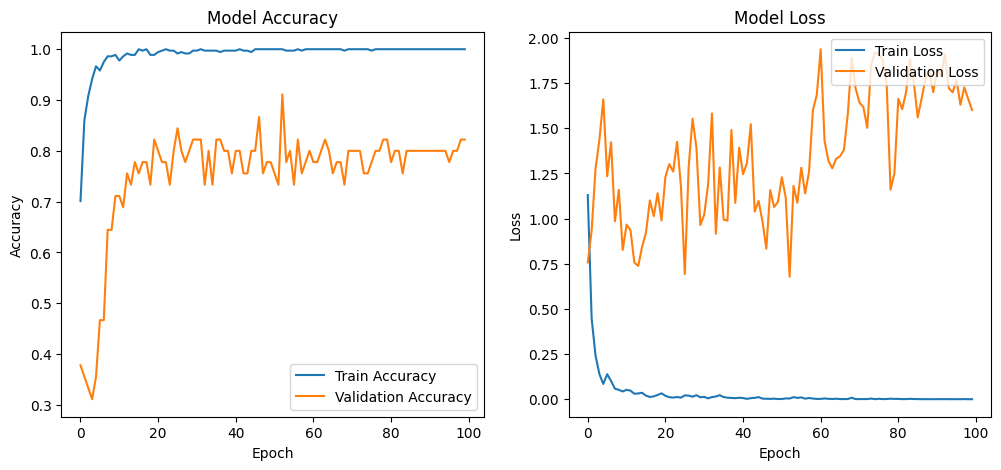

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

print("TensorFlow version:", tf.__version__)

# Assuming X_train, X_val, X_test, y_train, y_val, y_test are already defined and preprocessed

# Selecting only channels 6 and 14 from each feature set
# Note: Python uses 0-based indexing, so channels '6' and '14' are indexed as [6, 14]
X_train_selected = X_train[:, :, [5, 14]]
X_val_selected = X_val[:, :, [5, 14]]
X_test_selected = X_test[:, :, [5, 14]]

def build_lstm_model(input_shape, num_classes):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.5),
        LSTM(64),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=CategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

# Initialize the model
input_shape = (X_train_selected.shape[1], X_train_selected.shape[2])  # Shape is (sequence length, 2 channels)
num_classes = y_train.shape[1]
lstm_model = build_lstm_model(input_shape, num_classes)

# Train the model
epochs = 100  # Adjust epochs according to your need and computational power
batch_size = 10  # Adjust batch size according to your dataset and hardware capabilities
history = lstm_model.fit(X_train_selected, y_train, batch_size=batch_size, epochs=epochs,
                         validation_data=(X_val_selected, y_val), verbose=2)

# Evaluate the model on the test set using the selected channels
test_loss, test_acc = lstm_model.evaluate(X_test_selected, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")


TensorFlow version: 2.15.0
Epoch 1/100
36/36 - 21s - loss: 0.5807 - accuracy: 0.7793 - val_loss: 0.5708 - val_accuracy: 0.7556 - 21s/epoch - 573ms/step
Epoch 2/100
36/36 - 15s - loss: 0.5052 - accuracy: 0.8212 - val_loss: 0.5742 - val_accuracy: 0.7556 - 15s/epoch - 414ms/step
Epoch 3/100
36/36 - 15s - loss: 0.4854 - accuracy: 0.8240 - val_loss: 0.5745 - val_accuracy: 0.7556 - 15s/epoch - 430ms/step
Epoch 4/100
36/36 - 16s - loss: 0.4729 - accuracy: 0.8240 - val_loss: 0.5845 - val_accuracy: 0.7556 - 16s/epoch - 442ms/step
Epoch 5/100
36/36 - 15s - loss: 0.4964 - accuracy: 0.8240 - val_loss: 0.5632 - val_accuracy: 0.7556 - 15s/epoch - 424ms/step
Epoch 6/100
36/36 - 15s - loss: 0.4775 - accuracy: 0.8240 - val_loss: 0.5703 - val_accuracy: 0.7556 - 15s/epoch - 417ms/step
Epoch 7/100
36/36 - 15s - loss: 0.4662 - accuracy: 0.8268 - val_loss: 0.5694 - val_accuracy: 0.7556 - 15s/epoch - 409ms/step
Epoch 8/100
36/36 - 15s - loss: 0.4650 - accuracy: 0.8240 - val_loss: 0.5747 - val_accuracy: 0.755

# **ConvNetQuake** for 15 channels

Define the Model Architecture for ConvNetQuake

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.15.0


Compile the Model and Setup Training Configuration

In [ ]:
def build_model(input_shape, num_classes):
    model = Sequential()
    # Add convolutional layers with batch normalization and max pooling
    for _ in range(4):  # creating 4 blocks of Conv -> BN -> Activation -> Pooling
        model.add(Conv1D(filters=64, kernel_size=3, padding='same'))
        model.add(BatchNormalization())
        model.add(tf.keras.layers.ReLU())
        model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())
    # Dense layers for classification
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=CategoricalCrossentropy(label_smoothing=0.1),
                  metrics=['accuracy'])

    return model

print("Model function defined.")


Model function defined.


Prepare Data and Address Class Imbalance

In [ ]:
import h5py
import numpy as np

# Specify the path to the dataset
features_path = '/content/drive/MyDrive/Full Datasets (PTB and MIT)/Feature Extracted by Hatem/PTB_Features2.mat'

# Load the features and labels
with h5py.File(features_path, 'r') as file:
    # Dereference the object references to actual data
    # This assumes that each reference corresponds to a data array in the HDF5 file
    feature_data = [file[obj_ref] for obj_ref in file['f'][0]]
    features = np.array([np.array(fd) for fd in feature_data])

    print("Processed features shape:", features.shape)
    print("Sample features data (first record):", features[0])

labels_path = '/content/drive/MyDrive/Full Datasets (PTB and MIT)/Feature Extracted by Hatem/patientDiagnoses.mat'
label_data = loadmat(labels_path)
labels = [label[0] for label in label_data['patientInfo']['diagnosis'][0]]

print("Labels loaded. Sample label data:", labels[:5])


Processed features shape: (549, 526, 15)
Sample features data (first record): [[1.18859763 1.11292294 1.09849244 ... 1.50426876 1.12365284 1.15017675]
 [1.96283409 1.27665647 1.2697398  ... 7.50980444 1.46160407 2.02452865]
 [2.14899356 1.48317777 1.54008007 ... 4.91427325 1.97804444 4.0556222 ]
 ...
 [1.31307368 1.91657966 1.15201709 ... 1.43433499 1.26500452 1.16358645]
 [4.34883806 5.65980854 4.68132647 ... 5.9541247  5.80270735 5.92600598]
 [3.75424694 5.45015071 4.61794714 ... 4.66863816 5.97041526 6.71271564]]
Labels loaded. Sample label data: ['Valvular heart disease', 'Myocardial infarction', 'Myocardial infarction', 'n/a', 'Unstable angina']


In [ ]:
import h5py
import numpy as np

# Open the HDF5 file and directly access the 'f' dataset
features_path = '/content/drive/MyDrive/Full Datasets (PTB and MIT)/Feature Extracted by Hatem/PTB_Features2.mat'
with h5py.File(features_path, 'r') as file:
    # Assuming the actual data is nested within the first element of the first dimension
    nested_features = file['f'][0]  # This accesses the first row which should contain all the features
    features = np.array([np.array(file[ref]) for ref in nested_features])  # Dereferencing each HDF5 reference

print("Newly processed features shape:", features.shape)
print("Sample features data (first record):", features[0])

# Continue with the previous steps to filter features based on 'Healthy control' and 'Myocardial infarction'


Newly processed features shape: (549, 526, 15)
Sample features data (first record): [[1.18859763 1.11292294 1.09849244 ... 1.50426876 1.12365284 1.15017675]
 [1.96283409 1.27665647 1.2697398  ... 7.50980444 1.46160407 2.02452865]
 [2.14899356 1.48317777 1.54008007 ... 4.91427325 1.97804444 4.0556222 ]
 ...
 [1.31307368 1.91657966 1.15201709 ... 1.43433499 1.26500452 1.16358645]
 [4.34883806 5.65980854 4.68132647 ... 5.9541247  5.80270735 5.92600598]
 [3.75424694 5.45015071 4.61794714 ... 4.66863816 5.97041526 6.71271564]]


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Define the classes of interest
target_classes = ['Healthy control', 'Myocardial infarction']

# Filter labels to get indices for corresponding target classes
filtered_indices = [i for i, label in enumerate(labels) if label in target_classes]

# Print the filtered indices to ensure they're correctly calculated
print("Filtered indices:", filtered_indices[:10])  # Print first 10 indices to check

# Print the current shape of the features array before filtering
print("Current features shape before filtering:", features.shape)

# Use the filtered indices to select corresponding features and labels
filtered_features = features[filtered_indices]
filtered_labels = [labels[i] for i in filtered_indices]

# Initialize the label encoder and convert labels to integers
label_encoder = LabelEncoder()
labels_integer = label_encoder.fit_transform(filtered_labels)

# Convert integer labels to one-hot encoding
labels_encoded = to_categorical(labels_integer)

# Print the mapping of labels to integers
label_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}
print("Label mapping:", label_mapping)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(filtered_features, labels_encoded, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Data split into training, validation, and test sets.")
print(f"Training set shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, Validation labels shape: {y_val.shape}")
print(f"Test set shape: {X_test.shape}, Test labels shape: {y_test.shape}")


Filtered indices: [1, 2, 6, 7, 10, 12, 15, 17, 23, 31]
Current features shape before filtering: (549, 526, 15)
Label mapping: {0: 'Healthy control', 1: 'Myocardial infarction'}
Data split into training, validation, and test sets.
Training set shape: (358, 526, 15), Training labels shape: (358, 2)
Validation set shape: (45, 526, 15), Validation labels shape: (45, 2)
Test set shape: (45, 526, 15), Test labels shape: (45, 2)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam

def build_model(input_shape, num_classes):
    model = Sequential()
    # Define a model with several Conv1D and BatchNormalization layers followed by Activation
    model.add(Conv1D(filters=32, kernel_size=5, padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(filters=64, kernel_size=3, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(filters=128, kernel_size=3, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize the model
input_shape = (526, 15)  # From the feature dimensions
num_classes = 2  # Healthy control and Myocardial infarction
model = build_model(input_shape, num_classes)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 526, 32)           2432      
                                                                 
 batch_normalization (Batch  (None, 526, 32)           128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 526, 32)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 263, 32)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 263, 64)           6208      
                                                                 
 batch_normalization_1 (Bat  (None, 263, 64)           2

In [ ]:
# Training configurations
epochs = 100
batch_size = 10

# Fit the model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                    validation_data=(X_val, y_val), verbose=2)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")


Epoch 1/100
36/36 - 4s - loss: 0.6171 - accuracy: 0.7849 - val_loss: 0.6821 - val_accuracy: 0.5556 - 4s/epoch - 115ms/step
Epoch 2/100
36/36 - 2s - loss: 0.4021 - accuracy: 0.8380 - val_loss: 0.5606 - val_accuracy: 0.7556 - 2s/epoch - 43ms/step
Epoch 3/100
36/36 - 2s - loss: 0.3342 - accuracy: 0.8547 - val_loss: 0.3829 - val_accuracy: 0.8889 - 2s/epoch - 44ms/step
Epoch 4/100
36/36 - 1s - loss: 0.3376 - accuracy: 0.8547 - val_loss: 0.3838 - val_accuracy: 0.8667 - 1s/epoch - 33ms/step
Epoch 5/100
36/36 - 1s - loss: 0.2642 - accuracy: 0.8939 - val_loss: 0.3499 - val_accuracy: 0.8667 - 990ms/epoch - 28ms/step
Epoch 6/100
36/36 - 1s - loss: 0.2146 - accuracy: 0.9106 - val_loss: 0.3475 - val_accuracy: 0.8000 - 985ms/epoch - 27ms/step
Epoch 7/100
36/36 - 1s - loss: 0.1841 - accuracy: 0.9246 - val_loss: 0.3601 - val_accuracy: 0.8222 - 983ms/epoch - 27ms/step
Epoch 8/100
36/36 - 1s - loss: 0.1771 - accuracy: 0.9274 - val_loss: 0.3682 - val_accuracy: 0.8222 - 984ms/epoch - 27ms/step
Epoch 9/100

2/2 [==============================] - 0s 15ms/step
Overall Accuracy: 0.1333
Classification Report:
                       precision    recall  f1-score   support

      Healthy control       0.13      1.00      0.24         6
Myocardial infarction       0.00      0.00      0.00        39

             accuracy                           0.13        45
            macro avg       0.07      0.50      0.12        45
         weighted avg       0.02      0.13      0.03        45

Sensitivity (Recall for MI): 0.0000
Specificity (Recall for Healthy control): 1.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

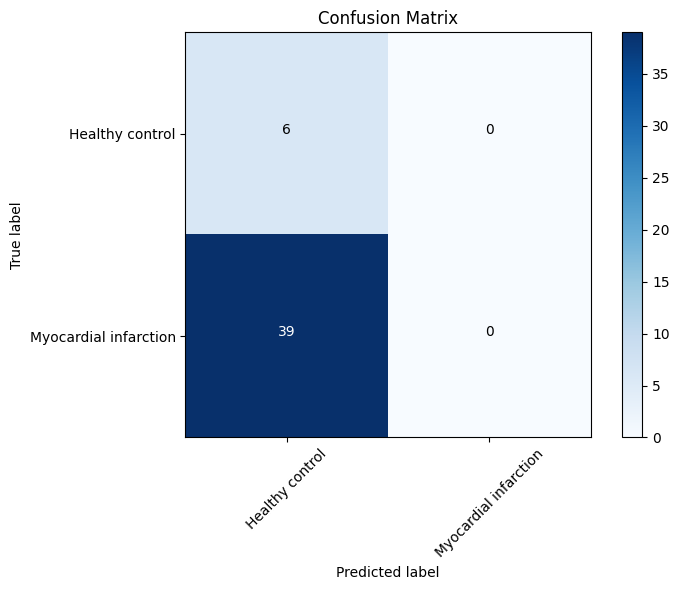

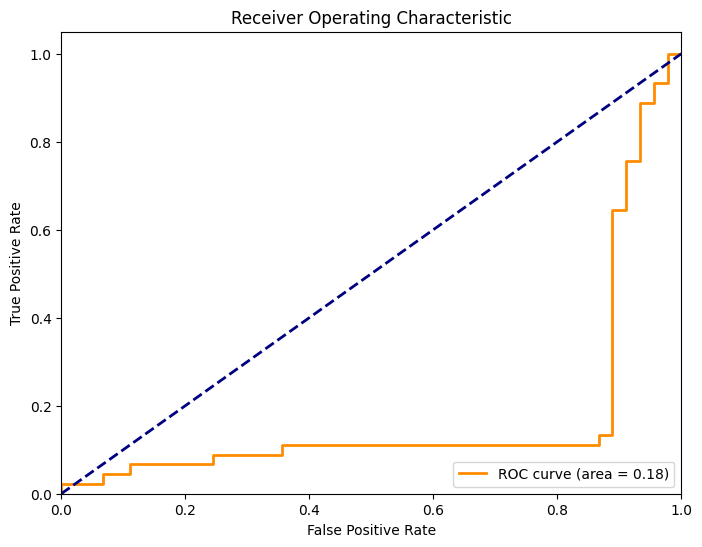

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.keras.utils import to_categorical

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculate the overall accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Overall Accuracy: {accuracy:.4f}")

# Calculate and print the classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_, output_dict=True)
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))

# Plotting the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, classes=label_encoder.classes_)

# Sensitivity and Specificity
sensitivity = report['Myocardial infarction']['recall']
specificity = report['Healthy control']['recall']
print(f"Sensitivity (Recall for MI): {sensitivity:.4f}")
print(f"Specificity (Recall for Healthy control): {specificity:.4f}")

# ROC Curve and AUC
y_test_bin = to_categorical(y_true_classes, num_classes=len(label_encoder.classes_))  # Binary format for ROC
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Training on channel 1
Epoch 1/100
36/36 - 6s - loss: 1.6056 - accuracy: 0.6536 - specificity: 0.6542 - sensitivity: 0.6542 - precision: 0.6542 - val_loss: 0.7247 - val_accuracy: 0.5333 - val_specificity: 0.5400 - val_sensitivity: 0.5400 - val_precision: 0.5400 - 6s/epoch - 168ms/step
Epoch 2/100
36/36 - 0s - loss: 0.8898 - accuracy: 0.7682 - specificity: 0.7687 - sensitivity: 0.7687 - precision: 0.7687 - val_loss: 1.2588 - val_accuracy: 0.2444 - val_specificity: 0.2800 - val_sensitivity: 0.2800 - val_precision: 0.2800 - 227ms/epoch - 6ms/step
Epoch 3/100
36/36 - 0s - loss: 0.5561 - accuracy: 0.8184 - specificity: 0.8174 - sensitivity: 0.8174 - precision: 0.8174 - val_loss: 1.8232 - val_accuracy: 0.2444 - val_specificity: 0.2800 - val_sensitivity: 0.2800 - val_precision: 0.2800 - 224ms/epoch - 6ms/step
Epoch 4/100
36/36 - 0s - loss: 0.3947 - accuracy: 0.8939 - specificity: 0.8937 - sensitivity: 0.8937 - precision: 0.8937 - val_loss: 1.4062 - val_accuracy: 0.2444 - val_specificity: 0.280

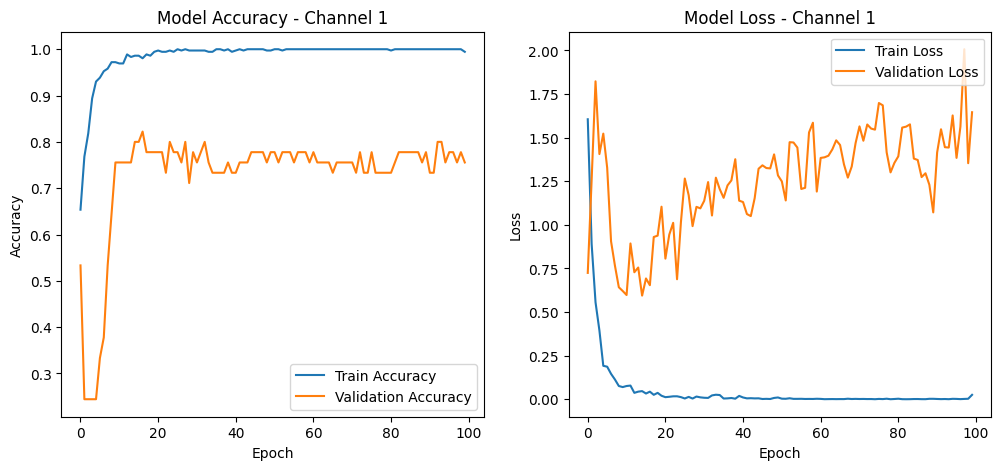

Training on channel 2
Epoch 1/100
36/36 - 3s - loss: 1.2186 - accuracy: 0.6899 - specificity: 0.6896 - sensitivity: 0.6896 - precision: 0.6896 - val_loss: 0.6984 - val_accuracy: 0.6444 - val_specificity: 0.6000 - val_sensitivity: 0.6000 - val_precision: 0.6000 - 3s/epoch - 79ms/step
Epoch 2/100
36/36 - 0s - loss: 0.5433 - accuracy: 0.8464 - specificity: 0.8465 - sensitivity: 0.8465 - precision: 0.8465 - val_loss: 0.7862 - val_accuracy: 0.3556 - val_specificity: 0.3400 - val_sensitivity: 0.3400 - val_precision: 0.3400 - 229ms/epoch - 6ms/step
Epoch 3/100
36/36 - 0s - loss: 0.3289 - accuracy: 0.8827 - specificity: 0.8833 - sensitivity: 0.8833 - precision: 0.8833 - val_loss: 1.0593 - val_accuracy: 0.2444 - val_specificity: 0.2400 - val_sensitivity: 0.2400 - val_precision: 0.2400 - 235ms/epoch - 7ms/step
Epoch 4/100
36/36 - 0s - loss: 0.2093 - accuracy: 0.9330 - specificity: 0.9319 - sensitivity: 0.9319 - precision: 0.9319 - val_loss: 0.7527 - val_accuracy: 0.4889 - val_specificity: 0.4800

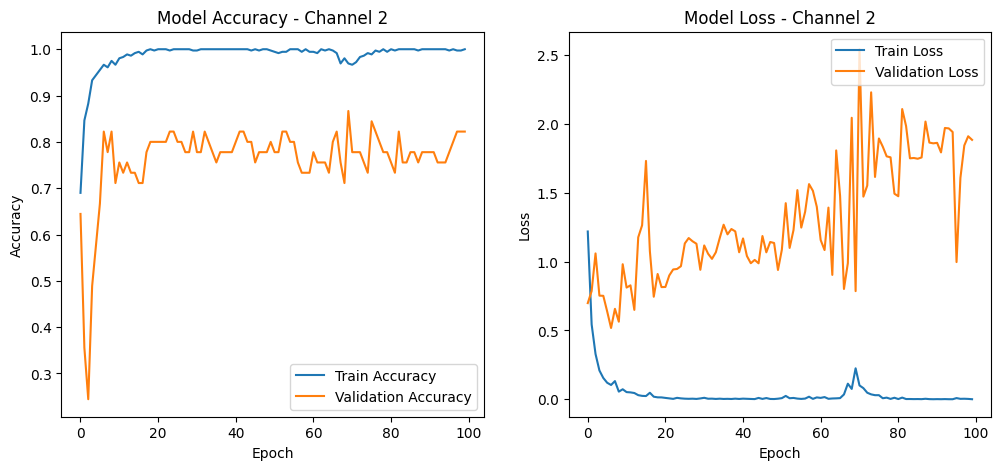

Training on channel 3
Epoch 1/100
36/36 - 3s - loss: 1.3985 - accuracy: 0.7011 - specificity: 0.7014 - sensitivity: 0.7014 - precision: 0.7014 - val_loss: 0.6679 - val_accuracy: 0.7556 - val_specificity: 0.7200 - val_sensitivity: 0.7200 - val_precision: 0.7200 - 3s/epoch - 71ms/step
Epoch 2/100
36/36 - 0s - loss: 0.4989 - accuracy: 0.8575 - specificity: 0.8569 - sensitivity: 0.8569 - precision: 0.8569 - val_loss: 0.7740 - val_accuracy: 0.6444 - val_specificity: 0.6200 - val_sensitivity: 0.6200 - val_precision: 0.6200 - 358ms/epoch - 10ms/step
Epoch 3/100
36/36 - 0s - loss: 0.3608 - accuracy: 0.8771 - specificity: 0.8764 - sensitivity: 0.8764 - precision: 0.8764 - val_loss: 0.9001 - val_accuracy: 0.5556 - val_specificity: 0.5400 - val_sensitivity: 0.5400 - val_precision: 0.5400 - 374ms/epoch - 10ms/step
Epoch 4/100
36/36 - 0s - loss: 0.3121 - accuracy: 0.8994 - specificity: 0.8993 - sensitivity: 0.8993 - precision: 0.8993 - val_loss: 1.2234 - val_accuracy: 0.5333 - val_specificity: 0.52

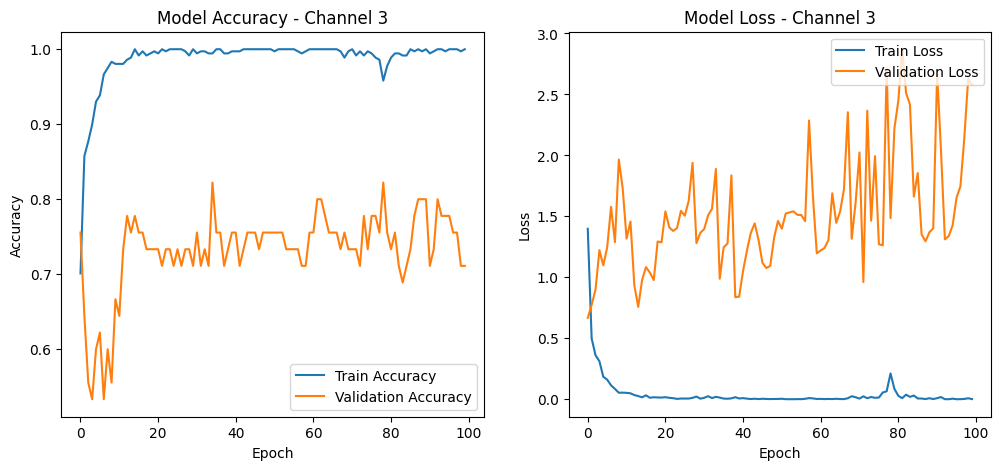

Training on channel 4
Epoch 1/100
36/36 - 4s - loss: 1.0397 - accuracy: 0.7095 - specificity: 0.7076 - sensitivity: 0.7076 - precision: 0.7076 - val_loss: 0.6855 - val_accuracy: 0.6889 - val_specificity: 0.6800 - val_sensitivity: 0.6800 - val_precision: 0.6800 - 4s/epoch - 117ms/step
Epoch 2/100
36/36 - 0s - loss: 0.5849 - accuracy: 0.8408 - specificity: 0.8410 - sensitivity: 0.8410 - precision: 0.8410 - val_loss: 0.9048 - val_accuracy: 0.2000 - val_specificity: 0.2400 - val_sensitivity: 0.2400 - val_precision: 0.2400 - 228ms/epoch - 6ms/step
Epoch 3/100
36/36 - 0s - loss: 0.5210 - accuracy: 0.8687 - specificity: 0.8694 - sensitivity: 0.8694 - precision: 0.8694 - val_loss: 0.6917 - val_accuracy: 0.5778 - val_specificity: 0.5800 - val_sensitivity: 0.5800 - val_precision: 0.5800 - 250ms/epoch - 7ms/step
Epoch 4/100
36/36 - 0s - loss: 0.2418 - accuracy: 0.8994 - specificity: 0.9000 - sensitivity: 0.9000 - precision: 0.9000 - val_loss: 0.7001 - val_accuracy: 0.5778 - val_specificity: 0.580

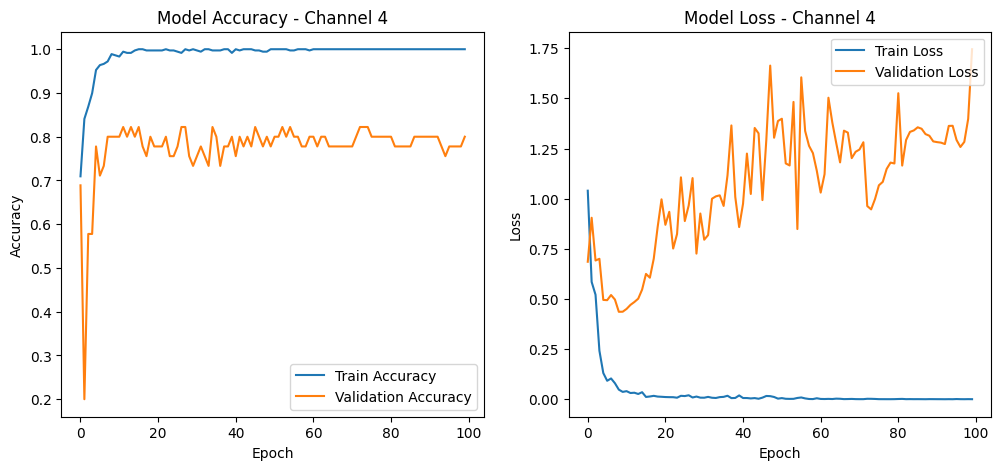

Training on channel 5
Epoch 1/100
36/36 - 3s - loss: 1.3947 - accuracy: 0.6397 - specificity: 0.6410 - sensitivity: 0.6410 - precision: 0.6410 - val_loss: 0.7664 - val_accuracy: 0.4667 - val_specificity: 0.4600 - val_sensitivity: 0.4600 - val_precision: 0.4600 - 3s/epoch - 74ms/step
Epoch 2/100
36/36 - 0s - loss: 0.5163 - accuracy: 0.8240 - specificity: 0.8236 - sensitivity: 0.8236 - precision: 0.8236 - val_loss: 1.0169 - val_accuracy: 0.2889 - val_specificity: 0.2800 - val_sensitivity: 0.2800 - val_precision: 0.2800 - 244ms/epoch - 7ms/step
Epoch 3/100
36/36 - 0s - loss: 0.3349 - accuracy: 0.8966 - specificity: 0.8958 - sensitivity: 0.8958 - precision: 0.8958 - val_loss: 1.5466 - val_accuracy: 0.2889 - val_specificity: 0.3000 - val_sensitivity: 0.3000 - val_precision: 0.3000 - 238ms/epoch - 7ms/step
Epoch 4/100
36/36 - 0s - loss: 0.2176 - accuracy: 0.9218 - specificity: 0.9222 - sensitivity: 0.9222 - precision: 0.9222 - val_loss: 1.6657 - val_accuracy: 0.3333 - val_specificity: 0.3400

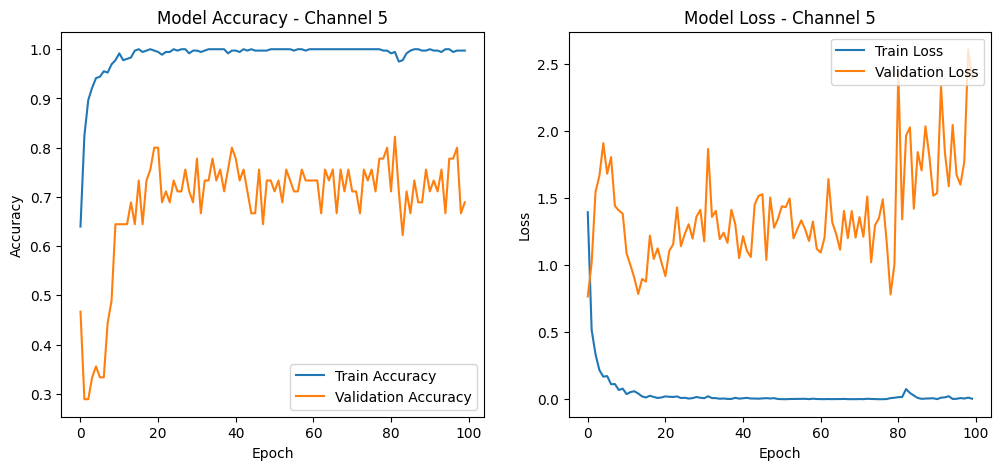

Training on channel 6
Epoch 1/100
36/36 - 3s - loss: 1.3134 - accuracy: 0.6508 - specificity: 0.6528 - sensitivity: 0.6528 - precision: 0.6528 - val_loss: 0.8749 - val_accuracy: 0.2667 - val_specificity: 0.2800 - val_sensitivity: 0.2800 - val_precision: 0.2800 - 3s/epoch - 71ms/step
Epoch 2/100
36/36 - 0s - loss: 0.5647 - accuracy: 0.8715 - specificity: 0.8708 - sensitivity: 0.8708 - precision: 0.8708 - val_loss: 1.5958 - val_accuracy: 0.2222 - val_specificity: 0.2200 - val_sensitivity: 0.2200 - val_precision: 0.2200 - 292ms/epoch - 8ms/step
Epoch 3/100
36/36 - 0s - loss: 0.3415 - accuracy: 0.8855 - specificity: 0.8861 - sensitivity: 0.8861 - precision: 0.8861 - val_loss: 2.3933 - val_accuracy: 0.2222 - val_specificity: 0.2400 - val_sensitivity: 0.2400 - val_precision: 0.2400 - 400ms/epoch - 11ms/step
Epoch 4/100
36/36 - 0s - loss: 0.2876 - accuracy: 0.9246 - specificity: 0.9236 - sensitivity: 0.9236 - precision: 0.9236 - val_loss: 2.7205 - val_accuracy: 0.2444 - val_specificity: 0.280

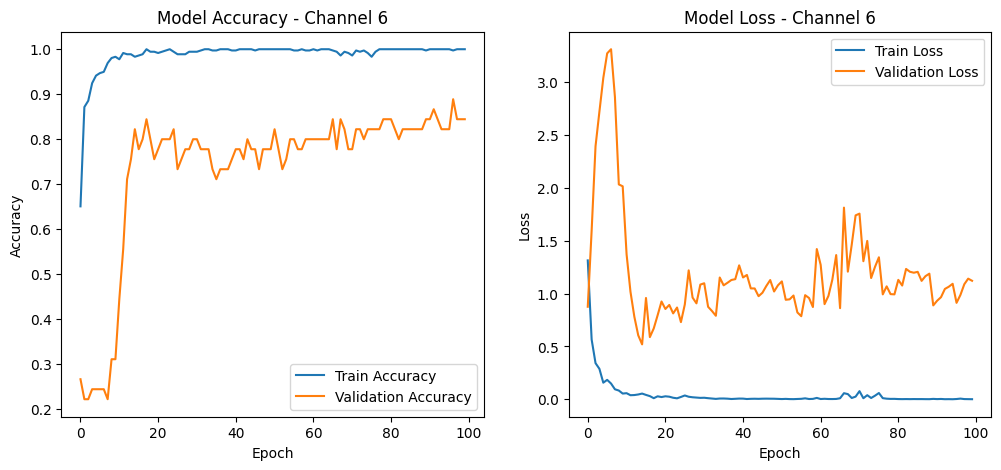

Training on channel 7
Epoch 1/100
36/36 - 3s - loss: 1.2278 - accuracy: 0.7235 - specificity: 0.7236 - sensitivity: 0.7236 - precision: 0.7236 - val_loss: 0.6492 - val_accuracy: 0.6222 - val_specificity: 0.5800 - val_sensitivity: 0.5800 - val_precision: 0.5800 - 3s/epoch - 91ms/step
Epoch 2/100
36/36 - 0s - loss: 0.6081 - accuracy: 0.8240 - specificity: 0.8250 - sensitivity: 0.8250 - precision: 0.8250 - val_loss: 0.5837 - val_accuracy: 0.7333 - val_specificity: 0.7000 - val_sensitivity: 0.7000 - val_precision: 0.7000 - 240ms/epoch - 7ms/step
Epoch 3/100
36/36 - 0s - loss: 0.4170 - accuracy: 0.8743 - specificity: 0.8743 - sensitivity: 0.8743 - precision: 0.8743 - val_loss: 0.5929 - val_accuracy: 0.7556 - val_specificity: 0.7200 - val_sensitivity: 0.7200 - val_precision: 0.7200 - 252ms/epoch - 7ms/step
Epoch 4/100
36/36 - 0s - loss: 0.3165 - accuracy: 0.8994 - specificity: 0.9000 - sensitivity: 0.9000 - precision: 0.9000 - val_loss: 0.6517 - val_accuracy: 0.7333 - val_specificity: 0.7000

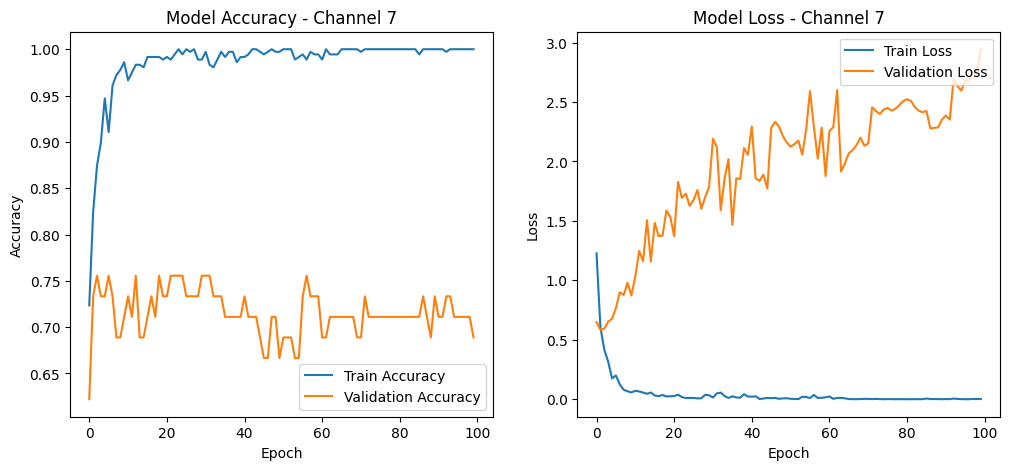

Training on channel 8
Epoch 1/100
36/36 - 3s - loss: 1.1134 - accuracy: 0.7374 - specificity: 0.7389 - sensitivity: 0.7389 - precision: 0.7389 - val_loss: 0.5824 - val_accuracy: 0.7556 - val_specificity: 0.7200 - val_sensitivity: 0.7200 - val_precision: 0.7200 - 3s/epoch - 71ms/step
Epoch 2/100
36/36 - 0s - loss: 0.4615 - accuracy: 0.8520 - specificity: 0.8521 - sensitivity: 0.8521 - precision: 0.8521 - val_loss: 0.5296 - val_accuracy: 0.7556 - val_specificity: 0.7200 - val_sensitivity: 0.7200 - val_precision: 0.7200 - 239ms/epoch - 7ms/step
Epoch 3/100
36/36 - 0s - loss: 0.2704 - accuracy: 0.8883 - specificity: 0.8875 - sensitivity: 0.8875 - precision: 0.8875 - val_loss: 0.5447 - val_accuracy: 0.7556 - val_specificity: 0.7200 - val_sensitivity: 0.7200 - val_precision: 0.7200 - 243ms/epoch - 7ms/step
Epoch 4/100
36/36 - 0s - loss: 0.1906 - accuracy: 0.9358 - specificity: 0.9354 - sensitivity: 0.9354 - precision: 0.9354 - val_loss: 0.6133 - val_accuracy: 0.7556 - val_specificity: 0.7200

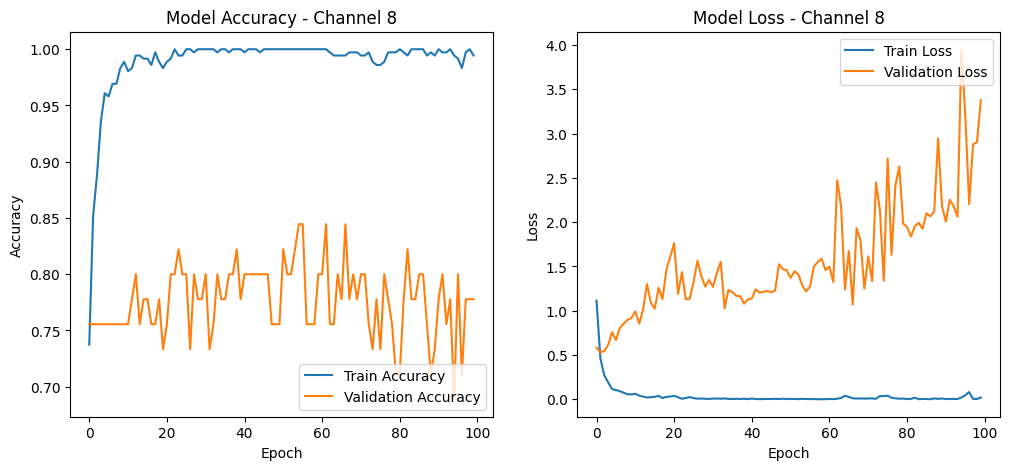

Training on channel 9
Epoch 1/100
36/36 - 3s - loss: 1.1071 - accuracy: 0.7514 - specificity: 0.7521 - sensitivity: 0.7521 - precision: 0.7521 - val_loss: 0.8465 - val_accuracy: 0.7111 - val_specificity: 0.6800 - val_sensitivity: 0.6800 - val_precision: 0.6800 - 3s/epoch - 80ms/step
Epoch 2/100
36/36 - 0s - loss: 0.6096 - accuracy: 0.8212 - specificity: 0.8215 - sensitivity: 0.8215 - precision: 0.8215 - val_loss: 0.8478 - val_accuracy: 0.4667 - val_specificity: 0.4600 - val_sensitivity: 0.4600 - val_precision: 0.4600 - 353ms/epoch - 10ms/step
Epoch 3/100
36/36 - 0s - loss: 0.3184 - accuracy: 0.8939 - specificity: 0.8937 - sensitivity: 0.8937 - precision: 0.8937 - val_loss: 0.9683 - val_accuracy: 0.5111 - val_specificity: 0.5000 - val_sensitivity: 0.5000 - val_precision: 0.5000 - 354ms/epoch - 10ms/step
Epoch 4/100
36/36 - 0s - loss: 0.2430 - accuracy: 0.9218 - specificity: 0.9215 - sensitivity: 0.9215 - precision: 0.9215 - val_loss: 0.9955 - val_accuracy: 0.5333 - val_specificity: 0.52

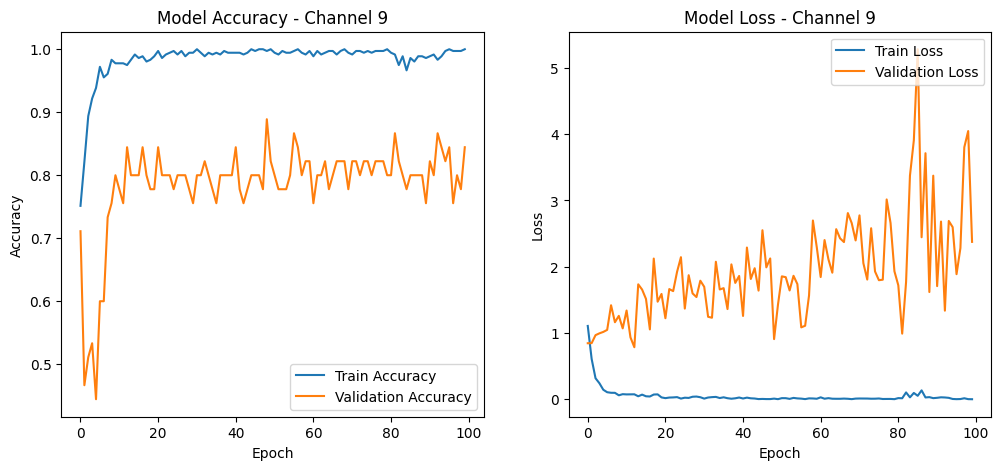

Training on channel 10
Epoch 1/100
36/36 - 3s - loss: 1.1459 - accuracy: 0.7458 - specificity: 0.7465 - sensitivity: 0.7465 - precision: 0.7465 - val_loss: 0.7009 - val_accuracy: 0.5556 - val_specificity: 0.5800 - val_sensitivity: 0.5800 - val_precision: 0.5800 - 3s/epoch - 78ms/step
Epoch 2/100
36/36 - 0s - loss: 0.8059 - accuracy: 0.8212 - specificity: 0.8222 - sensitivity: 0.8222 - precision: 0.8222 - val_loss: 0.6038 - val_accuracy: 0.6222 - val_specificity: 0.6400 - val_sensitivity: 0.6400 - val_precision: 0.6400 - 242ms/epoch - 7ms/step
Epoch 3/100
36/36 - 0s - loss: 0.3942 - accuracy: 0.8268 - specificity: 0.8271 - sensitivity: 0.8271 - precision: 0.8271 - val_loss: 0.5371 - val_accuracy: 0.8000 - val_specificity: 0.7600 - val_sensitivity: 0.7600 - val_precision: 0.7600 - 242ms/epoch - 7ms/step
Epoch 4/100
36/36 - 0s - loss: 0.2756 - accuracy: 0.9106 - specificity: 0.9104 - sensitivity: 0.9104 - precision: 0.9104 - val_loss: 0.6620 - val_accuracy: 0.6889 - val_specificity: 0.660

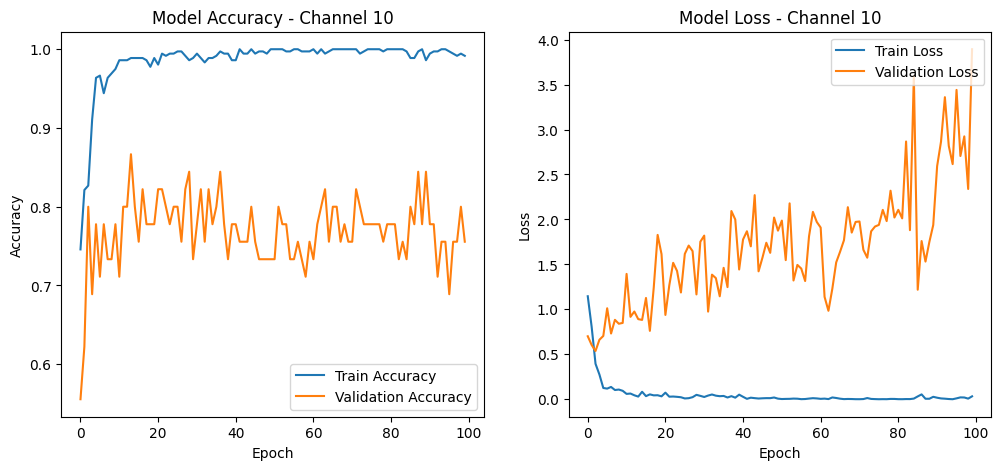

Training on channel 11
Epoch 1/100
36/36 - 3s - loss: 1.0698 - accuracy: 0.7430 - specificity: 0.7437 - sensitivity: 0.7437 - precision: 0.7437 - val_loss: 0.7183 - val_accuracy: 0.5778 - val_specificity: 0.5600 - val_sensitivity: 0.5600 - val_precision: 0.5600 - 3s/epoch - 71ms/step
Epoch 2/100
36/36 - 0s - loss: 0.5630 - accuracy: 0.8324 - specificity: 0.8319 - sensitivity: 0.8319 - precision: 0.8319 - val_loss: 0.7823 - val_accuracy: 0.3778 - val_specificity: 0.3800 - val_sensitivity: 0.3800 - val_precision: 0.3800 - 253ms/epoch - 7ms/step
Epoch 3/100
36/36 - 0s - loss: 0.2996 - accuracy: 0.9078 - specificity: 0.9083 - sensitivity: 0.9083 - precision: 0.9083 - val_loss: 0.8816 - val_accuracy: 0.4000 - val_specificity: 0.4600 - val_sensitivity: 0.4600 - val_precision: 0.4600 - 245ms/epoch - 7ms/step
Epoch 4/100
36/36 - 0s - loss: 0.2302 - accuracy: 0.9246 - specificity: 0.9250 - sensitivity: 0.9250 - precision: 0.9250 - val_loss: 0.9640 - val_accuracy: 0.4000 - val_specificity: 0.400

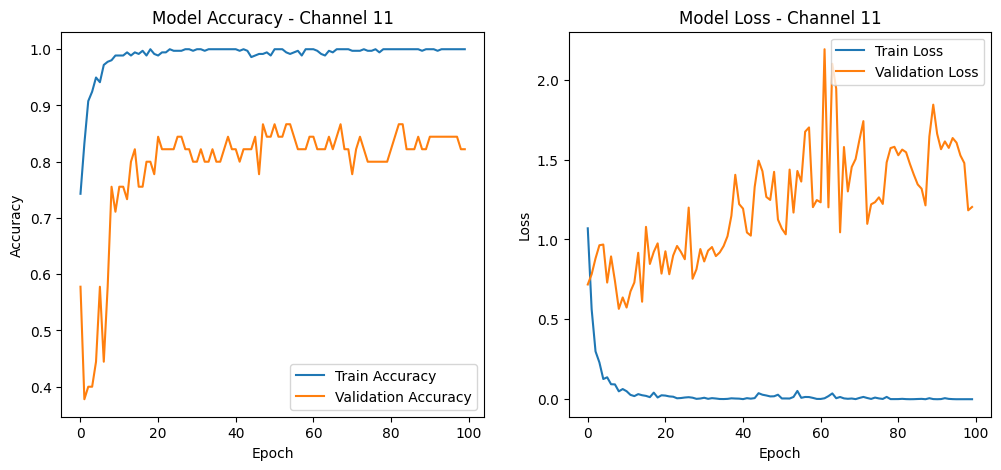

Training on channel 12
Epoch 1/100
36/36 - 3s - loss: 1.4275 - accuracy: 0.6899 - specificity: 0.6903 - sensitivity: 0.6903 - precision: 0.6903 - val_loss: 0.6888 - val_accuracy: 0.5111 - val_specificity: 0.5000 - val_sensitivity: 0.5000 - val_precision: 0.5000 - 3s/epoch - 75ms/step
Epoch 2/100
36/36 - 0s - loss: 0.5383 - accuracy: 0.8436 - specificity: 0.8444 - sensitivity: 0.8444 - precision: 0.8444 - val_loss: 0.9612 - val_accuracy: 0.3111 - val_specificity: 0.3000 - val_sensitivity: 0.3000 - val_precision: 0.3000 - 359ms/epoch - 10ms/step
Epoch 3/100
36/36 - 0s - loss: 0.3661 - accuracy: 0.8855 - specificity: 0.8840 - sensitivity: 0.8840 - precision: 0.8840 - val_loss: 1.1488 - val_accuracy: 0.4000 - val_specificity: 0.4400 - val_sensitivity: 0.4400 - val_precision: 0.4400 - 366ms/epoch - 10ms/step
Epoch 4/100
36/36 - 0s - loss: 0.2087 - accuracy: 0.9330 - specificity: 0.9333 - sensitivity: 0.9333 - precision: 0.9333 - val_loss: 1.2163 - val_accuracy: 0.3111 - val_specificity: 0.3

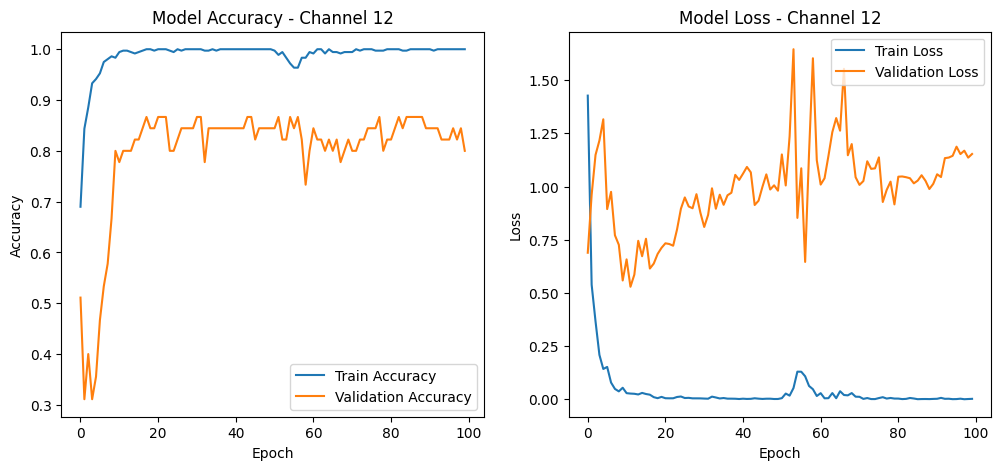

Training on channel 13
Epoch 1/100
36/36 - 3s - loss: 1.1347 - accuracy: 0.7151 - specificity: 0.7167 - sensitivity: 0.7167 - precision: 0.7167 - val_loss: 0.7217 - val_accuracy: 0.5556 - val_specificity: 0.5600 - val_sensitivity: 0.5600 - val_precision: 0.5600 - 3s/epoch - 80ms/step
Epoch 2/100
36/36 - 0s - loss: 0.6074 - accuracy: 0.8324 - specificity: 0.8319 - sensitivity: 0.8319 - precision: 0.8319 - val_loss: 1.1426 - val_accuracy: 0.3333 - val_specificity: 0.3600 - val_sensitivity: 0.3600 - val_precision: 0.3600 - 241ms/epoch - 7ms/step
Epoch 3/100
36/36 - 0s - loss: 0.3548 - accuracy: 0.8687 - specificity: 0.8681 - sensitivity: 0.8681 - precision: 0.8681 - val_loss: 1.3005 - val_accuracy: 0.3556 - val_specificity: 0.3600 - val_sensitivity: 0.3600 - val_precision: 0.3600 - 252ms/epoch - 7ms/step
Epoch 4/100
36/36 - 0s - loss: 0.2212 - accuracy: 0.9497 - specificity: 0.9500 - sensitivity: 0.9500 - precision: 0.9500 - val_loss: 1.7011 - val_accuracy: 0.3333 - val_specificity: 0.360

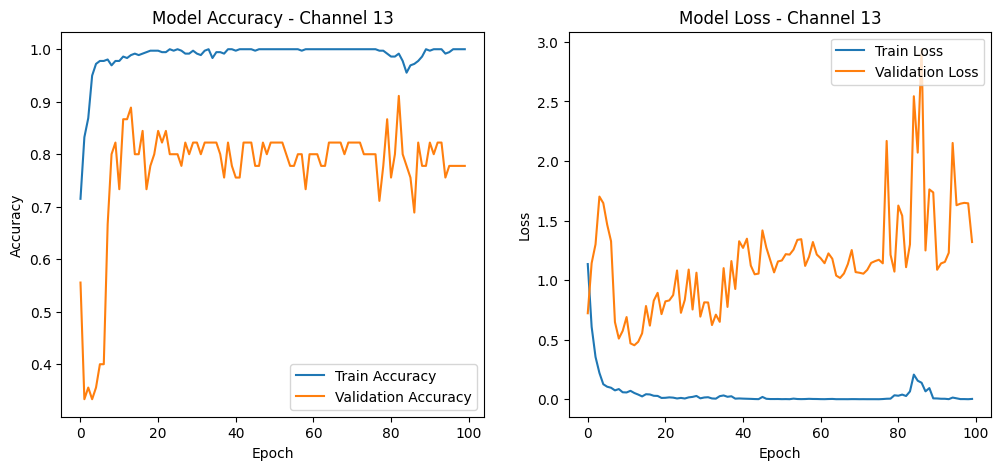

Training on channel 14
Epoch 1/100
36/36 - 3s - loss: 1.5667 - accuracy: 0.6816 - specificity: 0.6806 - sensitivity: 0.6806 - precision: 0.6806 - val_loss: 0.7630 - val_accuracy: 0.3778 - val_specificity: 0.3800 - val_sensitivity: 0.3800 - val_precision: 0.3800 - 3s/epoch - 72ms/step
Epoch 2/100
36/36 - 0s - loss: 0.6988 - accuracy: 0.8212 - specificity: 0.8208 - sensitivity: 0.8208 - precision: 0.8208 - val_loss: 1.2083 - val_accuracy: 0.2889 - val_specificity: 0.3400 - val_sensitivity: 0.3400 - val_precision: 0.3400 - 254ms/epoch - 7ms/step
Epoch 3/100
36/36 - 0s - loss: 0.4800 - accuracy: 0.8380 - specificity: 0.8389 - sensitivity: 0.8389 - precision: 0.8389 - val_loss: 1.5288 - val_accuracy: 0.2667 - val_specificity: 0.3200 - val_sensitivity: 0.3200 - val_precision: 0.3200 - 269ms/epoch - 7ms/step
Epoch 4/100
36/36 - 0s - loss: 0.3203 - accuracy: 0.8911 - specificity: 0.8910 - sensitivity: 0.8910 - precision: 0.8910 - val_loss: 1.6425 - val_accuracy: 0.2667 - val_specificity: 0.320

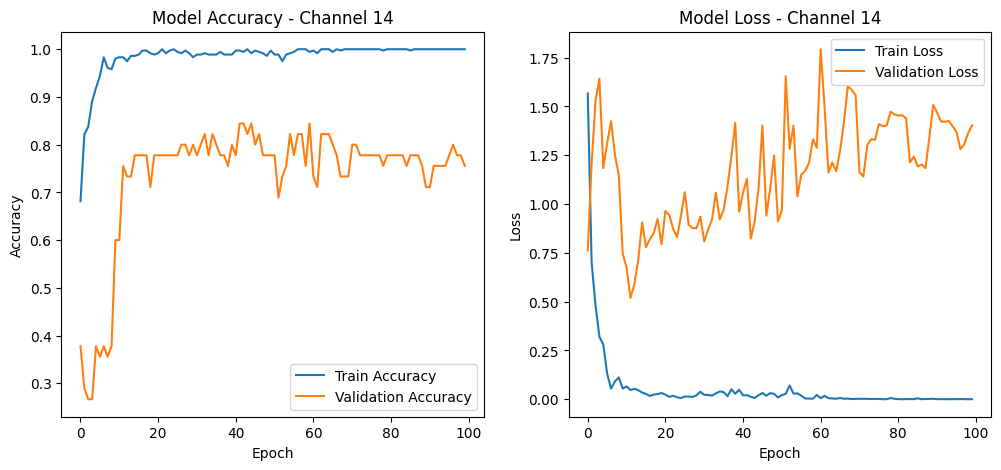

Training on channel 15
Epoch 1/100
36/36 - 3s - loss: 1.2021 - accuracy: 0.7374 - specificity: 0.7375 - sensitivity: 0.7375 - precision: 0.7375 - val_loss: 0.7105 - val_accuracy: 0.6444 - val_specificity: 0.6200 - val_sensitivity: 0.6200 - val_precision: 0.6200 - 3s/epoch - 79ms/step
Epoch 2/100
36/36 - 0s - loss: 0.5738 - accuracy: 0.8492 - specificity: 0.8486 - sensitivity: 0.8486 - precision: 0.8486 - val_loss: 0.6279 - val_accuracy: 0.6444 - val_specificity: 0.6200 - val_sensitivity: 0.6200 - val_precision: 0.6200 - 372ms/epoch - 10ms/step
Epoch 3/100
36/36 - 0s - loss: 0.3901 - accuracy: 0.8799 - specificity: 0.8799 - sensitivity: 0.8799 - precision: 0.8799 - val_loss: 1.0635 - val_accuracy: 0.2667 - val_specificity: 0.3000 - val_sensitivity: 0.3000 - val_precision: 0.3000 - 377ms/epoch - 10ms/step
Epoch 4/100
36/36 - 0s - loss: 0.2613 - accuracy: 0.9162 - specificity: 0.9160 - sensitivity: 0.9160 - precision: 0.9160 - val_loss: 0.9052 - val_accuracy: 0.4222 - val_specificity: 0.4

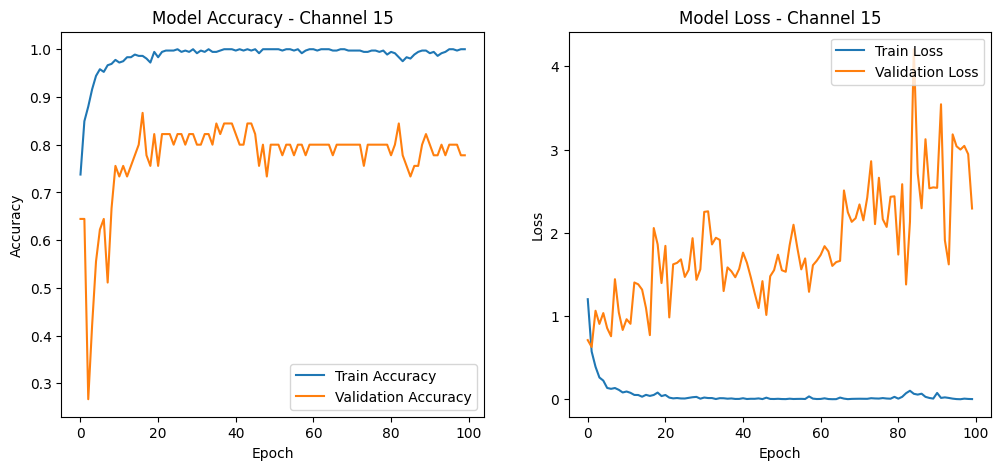

Channel 1 - Test accuracy: 0.8667, Test loss: 0.5984, Test specificity: 0.9062, Test sensitivity: 0.9062, Test precision: 0.9062
Channel 2 - Test accuracy: 0.8222, Test loss: 1.7529, Test specificity: 0.8750, Test sensitivity: 0.8750, Test precision: 0.8750
Channel 3 - Test accuracy: 0.7778, Test loss: 0.6375, Test specificity: 0.7981, Test sensitivity: 0.7981, Test precision: 0.7981
Channel 4 - Test accuracy: 0.8444, Test loss: 0.8636, Test specificity: 0.8906, Test sensitivity: 0.8906, Test precision: 0.8906
Channel 5 - Test accuracy: 0.9111, Test loss: 0.7287, Test specificity: 0.9375, Test sensitivity: 0.9375, Test precision: 0.9375
Channel 6 - Test accuracy: 0.8444, Test loss: 0.7884, Test specificity: 0.8678, Test sensitivity: 0.8678, Test precision: 0.8678
Channel 7 - Test accuracy: 0.8222, Test loss: 1.2221, Test specificity: 0.8750, Test sensitivity: 0.8750, Test precision: 0.8750
Channel 8 - Test accuracy: 0.8444, Test loss: 2.1494, Test specificity: 0.8906, Test sensitivity:

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt

def build_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=CategoricalCrossentropy(),
                  metrics=['accuracy', specificity, sensitivity, precision])
    return model

num_channels = 15  # assuming 15 channels
channel_results = []

for i in range(num_channels):
    print(f"Training on channel {i+1}")
    X_train_selected = X_train[:, :, i:i+1]
    X_val_selected = X_val[:, :, i:i+1]
    X_test_selected = X_test[:, :, i:i+1]

    input_shape = (X_train_selected.shape[1], 1)  # since we're using one channel at a time
    num_classes = y_train.shape[1]

    model = build_model(input_shape, num_classes)

    # Training the model
    history = model.fit(X_train_selected, y_train, batch_size=10, epochs=100,
                        validation_data=(X_val_selected, y_val), verbose=2)

    # Evaluating the model
    test_metrics = model.evaluate(X_test_selected, y_test, verbose=2)
    channel_results.append(test_metrics)

    # Plotting results (for each channel you might want to save these plots or show them differently)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Model Accuracy - Channel {i+1}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model Loss - Channel {i+1}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

# Print all channel results
for idx, metrics in enumerate(channel_results):
    print(f"Channel {idx+1} - Test accuracy: {metrics[1]:.4f}, Test loss: {metrics[0]:.4f}, " +
          f"Test specificity: {metrics[2]:.4f}, Test sensitivity: {metrics[3]:.4f}, Test precision: {metrics[4]:.4f}")
